In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout

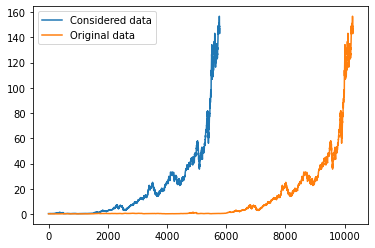

In [2]:
aapl = pd.read_csv('/Users/konstantinkuchenmeister/Downloads/aapl.csv')
#apple = aapl.iloc[:, 4:5].values
apple = aapl.iloc[4500:, 4:5].values

# We are cutting away the first 4500 values, since this this time frame featured an insubtantial
# first and second moments. Empirically, I found that this holds the model back from modelling the 
# steep increase throughout the last 3500 days.
plt.plot(aapl.iloc[4500:, 4:5].values, label="Considered data")
plt.plot(aapl.iloc[:, 4:5].values, label="Original data")
plt.legend(loc='best')
plt.show()

In [3]:
def scaleData(series):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(series)
    print("Data was successfully scaled.")
    return scaled

In [4]:
def splitData(series, splitPercent):
    rowCount = len(series)
    trainSize = int(rowCount * splitPercent)
    train = series[:trainSize]
    test = series[trainSize:]
    print("Data was successfully split from " + str(rowCount) + " into ", end='')
    print("Train: " + str(len(train)), end=' ')
    print("Test: " + str(len(test)))
    return train, test

In [5]:
def prepareData(series, windowSize):
    features = []
    labels = []
    for index in range(windowSize, len(series)):
        features.append(series[index-windowSize:index, 0])
        labels.append(series[index, 0])
    features, labels = np.array(features), np.array(labels)
    return features, labels

In [6]:
def lstmModel(tFeatures, tLabels, epochs, batchCount):
    model = Sequential()
    # Combatting overfitting
    model.add(LSTM(units = 60, return_sequences = True, input_shape=(tFeatures.shape[1], 1)))
    #model.add(Dropout(0.2))
    
    #model.add(LSTM(units = 80, return_sequences = True))
    #model.add(Dropout(0.2))
    
    #model.add(LSTM(units = 100, return_sequences = True))
    #model.add(Dropout(0.2))
    
    model.add(LSTM(units = 60))
    
    model.add(Dense(units = 1)) # Final dense/output layer for single output
    
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    history = model.fit(tFeatures, tLabels, validation_split = 0.1, epochs = epochs, batch_size = batchCount)
    return model, history

In [7]:
def invertScale(forecasts, series):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scale = scaler.fit(series)
    forecasts_scaled = scale.inverse_transform(forecasts)
    return forecasts_scaled

In [8]:
def visualizePredictions(testLength, predictions, windowSize):
    trueData = pd.read_csv('/Users/konstantinkuchenmeister/Downloads/aapl.csv').iloc[-testLength:, 4:5].values
    plt.figure(figsize=(20,10))
    plt.plot(trueData, color='green', label='AAPL')
    predictionX = list(range(windowSize, len(trueData))) # to account for last values not being considered due to out of bounds in preparedata
    plt.plot(predictionX, predictions, color='red', label='Predicted AAPL')
    plt.title('LSTM AAPL Single Day Prediction')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [9]:
# Single Week prediction using recursive strategy
# Recursive Multi-step Forecast
# https://machinelearningmastery.com/multi-step-time-series-forecasting/

def makeMultiStepPrediction(lBatch, forecastLength):
    # Shape has to be 1,windowSize,1
    lBatchReshaped = np.reshape(lBatch, (lBatch.shape[1], lBatch.shape[0], 1))
    
    # print(lBatchReshaped)

    lPrediction = model.predict(lBatchReshaped)

    windowX = list(lBatchReshaped[0]) # The window of length 7 that stores the current featureWindow
    results = list() # Storing the results

    for index in range(0, forecastLength):
        windowX.pop(0) # Drop the first observation of the sliding window
        windowX.append(lPrediction[0]) # Append the current prediction
    
        lBatchReshaped[0] = windowX # update the featureBatch
    
        fPrediction = model.predict(lBatchReshaped) # make the current prediction
    
        fPredictionScaled = invertScale(fPrediction, apple) # invert the prediction
        
        lPrediction[0] = fPrediction # for updating the windowX
        
        results.append(fPredictionScaled) # storing the result
    

    flattenedResults = list()
    for val in results:
        flattenedResults.append(val[0])
        
    return flattenedResults

In [10]:
def visualizePerformance(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.legend(loc='best')
    plt.show()

In [19]:
# timePoints: An array of timepoints that marks the last day of a windowsize-day batch that should be used for
# forecasting
def makeMultiMultiStepPrediction(timePoints, forecastLength):
    returnArr = np.zeros((len(timePoints),2, forecastLength))
    tmp = 0
    # 1. Check if the array of timepoints is valid
    for val in timePoints:
        if val <= len(test) and val > 50 :
            upper = -((len(test))-val)
            lower = -((len(test))-val)-50
            cBatch = np.array(data[lower:upper])
            multiStepResults = makeMultiStepPrediction(cBatch, forecastLength)
            multiStepX = np.arange(val, val+6)
            
            returnArr[tmp, 0, :] = multiStepX
            returnArr[tmp, 1, :] = multiStepResults
            
            tmp = tmp+1
        else:
            print("Timepoint %d is invalid", val)
        
    return returnArr

def visualizeMultiMultiStepPrediction(results):
    plt.figure(figsize=(30,15))
    for index in range(0, results.shape[0]):
        lower = results[index, 0, 0]
        upper = results[index, 0, results.shape[2]-1]
        label_ = ("Prediction period: %d - %d" % (lower, upper))
        plt.plot(results[index, 0, :], results[index, 1, :], label = label_, color = "red")
        plt.legend(loc="best")
    trueData = pd.read_csv('/Users/konstantinkuchenmeister/Downloads/aapl.csv').iloc[-len(test):, 4:5].values
    plt.plot(trueData, color="green")
    plt.legend(loc="best")
    plt.show()

Data was successfully scaled.
Data was successfully split from 5784 into Train: 4916 Test: 868
[[0.00053914 0.00050348 0.00033941 ... 0.00033227 0.00032871 0.00032871]
 [0.00050348 0.00033941 0.00036081 ... 0.00032871 0.00032871 0.00042857]
 [0.00033941 0.00036081 0.00032514 ... 0.00032871 0.00042857 0.00035724]
 ...
 [0.26530328 0.2660383  0.26659757 ... 0.2702248  0.27533806 0.27404377]
 [0.2660383  0.26659757 0.25496489 ... 0.27533806 0.27404377 0.27676019]
 [0.26659757 0.25496489 0.24855733 ... 0.27404377 0.27676019 0.27770294]]
[0.00042857 0.00035724 0.00041788 ... 0.27676019 0.27770294 0.27944467]
(4866, 50, 1)
Epoch 1/2
69/69 [==============================] - 4s 35ms/step - loss: 3.7337e-04 - val_loss: 8.0720e-05
Epoch 2/2
69/69 [==============================] - 2s 28ms/step - loss: 1.2810e-05 - val_loss: 4.9772e-05


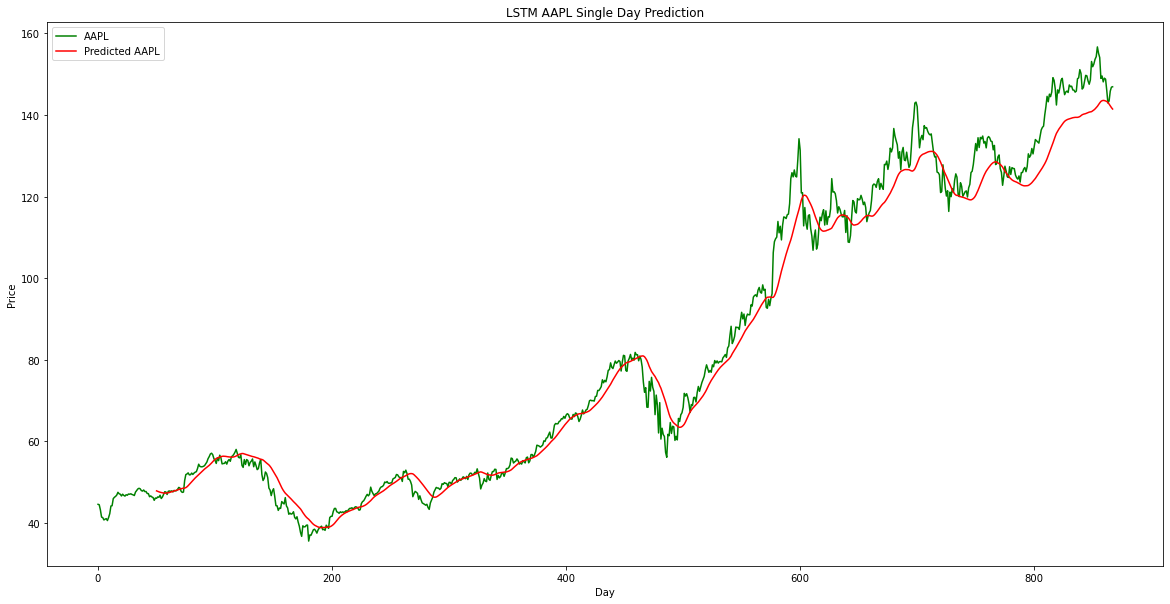

In [12]:
# Single day prediction
data = scaleData(apple)

splitPercentage = .85

train, test = splitData(data, splitPercentage)

windowSize = 50
trainFeatures, trainLabels = prepareData(train, windowSize)
testFeatures, testLabels = prepareData(test, windowSize)

print(trainFeatures)
print(trainLabels)

features = np.reshape(trainFeatures, (trainFeatures.shape[0], trainFeatures.shape[1], 1))

print(features.shape) # (rows, columns, step)

model, history = lstmModel(features, trainLabels, 2, 64)
testFeatures = np.reshape(testFeatures, (testFeatures.shape[0], testFeatures.shape[1], 1))
predictions = model.predict(testFeatures)

predictions = invertScale(predictions, apple)

visualizePredictions(len(test), predictions, windowSize)

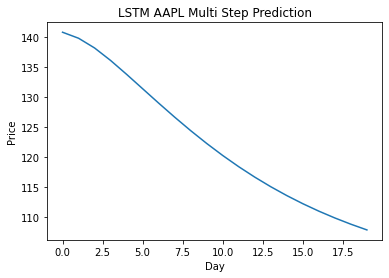

In [13]:
# The multistep prediction for the last date of the data + 20

lBatch = np.array(data[-50:])

multiStepResults = makeMultiStepPrediction(lBatch, 20)

plt.plot(multiStepResults, label = 'Predicted')
plt.title('LSTM AAPL Multi Step Prediction')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

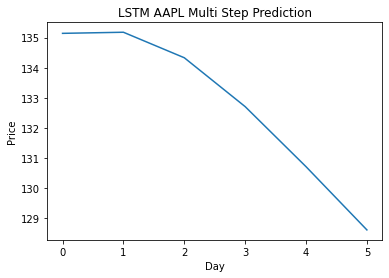

In [14]:
# The multistep prediction for the last date of the data + 6

lBatch = np.array(data[-100:-50])
multiStepResults = makeMultiStepPrediction(lBatch, 6)

plt.plot(multiStepResults, label = 'Predicted')
plt.title('LSTM AAPL Multi Step Prediction')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

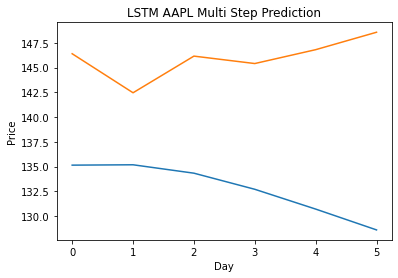

In [15]:
# In order to be able to compare our multi-step prediction results, we attempt to predict the following:
# Let x denote the index of the last day of the dataset
# Take the window [x - 100, x - 50] to predict the values [x-50+1, x-50+5].
# We are basically shifting our unknown state of the world back in time, pretending these observations have not yet
# happened.
# This allows us, to compare our multistep prediction of [x-50+1, x-50+5] to the actual [x-50+1, x-50+5] data.

lBatch = np.array(data[-100:-50])

multiStepResults = makeMultiStepPrediction(lBatch, 6)

actualResults = invertScale(np.array(data[-50:-44]), apple)

plt.plot(multiStepResults, label="Predicted values")
plt.plot(actualResults, label="Original data")
plt.title('LSTM AAPL Multi Step Prediction')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

In [16]:
lBatch = np.array(data[-100:-50])

lBatchReshaped = np.reshape(lBatch, (lBatch.shape[1], lBatch.shape[0], 1))

print(lBatchReshaped.shape)

predict = model.predict(lBatchReshaped)

predict = invertScale(predict, apple)
print(predict)

(1, 50, 1)
[[134.77126]]


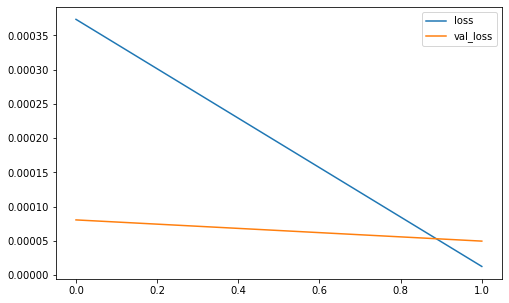

In [17]:
visualizePerformance(history)

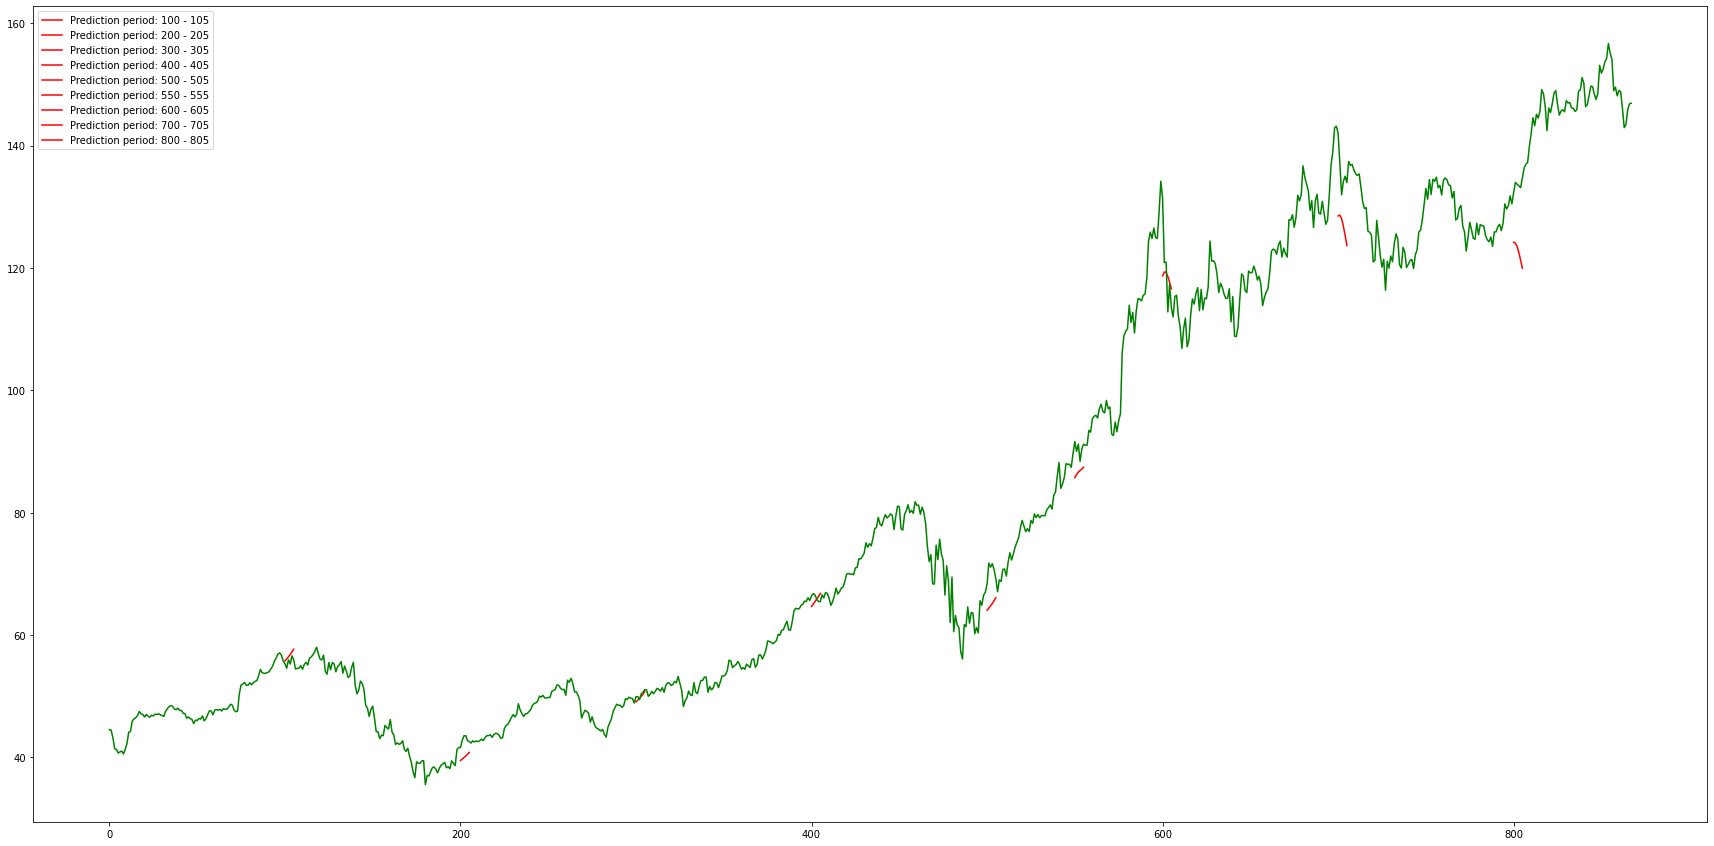

In [24]:
res = makeMultiMultiStepPrediction([100, 200, 300, 400, 500, 550, 600, 700, 800],6)
visualizeMultiMultiStepPrediction(res)